In [1]:
from forex import *
import torch
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import random
import pandas as pd
import torch.nn.functional as F
import math
from envs import Market
from tqdm import tqdm
from itertools import count

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
device


'cuda'

In [2]:
Transition = namedtuple('Transition', 
                        ('state','action','next_state','reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
env = Market("EURUSD","min",add_sentiment = True)
# state, reward, done, info
# array, float, bool, dict

BATCH_SIZE = 64
GAMMA = 0.2
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000
TAU = 0.05
LR = 1e-2

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    #   Knows
    # -----------------------------
    loss_fn = nn.SmoothL1Loss()
    loss = loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1 * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
                # Picks action with highest expected reward
            return policy_net(torch.tensor(state.detach().clone()).type(torch.float)).detach().clone().max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [4]:
class DQN  (nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()

        self.Rlayer1 = nn.Linear(10,20)
        self.Rlayer2 = nn.Linear(20,128)

        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3  = nn.Linear(128,128)
        self.layer4 = nn.Linear(128, n_actions)
    def forward(self, x):
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
        r = F.relu(self.Rlayer1(torch.randn(1,10).to(device)))
        r = F.relu(self.Rlayer2(r))
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))

        x = x * r

        x = F.relu(self.layer3(x))


        return self.layer4(x)
    

num_episodes = 4000


episode_durations = []

# Get number of actions from gym action space
# sell, close, hold, buy
n_actions = env.action_space.n

#  Get the number of state observations
state, info = env.reset()
n_observations = len(state) 

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device) 
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

# if torch.cuda.is_available():
#     num_episodes = 40
# else:
#     num_episodes = 60


arr_preformance = []
episode_durations = []
for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and get it's state
 
    state, info = env.reset(random_start=True)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    start_idx = env.idx

    for t in count():
    
        action = select_action(state)
        
        # 0 -> hold, 1 -> buy, 2 -> sell, 3 -> close, 
        
        observation, reward, terminated, truncated= env.step(action)
        
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(start_idx - env.idx + 1)
            arr_preformance.append(env.avali)
            steps_done = 0
            break


fig = plt.figure(figsize=(10,10))

fig.add_subplot(3,3,1)
plt.title("Preformance")
plt.plot(arr_preformance)


fig.add_subplot(3,3,2)
plt.title("Duration (idx)")
plt.plot(episode_durations)
env.reset()


  0%|          | 0/4000 [00:00<?, ?it/s]

/tmp/ipykernel_3257/1974816204.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return policy_net(torch.tensor(state.detach().clone()).type(torch.float)).detach().clone().max(1)[1].view(1, 1)
  5%|▍         | 181/4000 [2:48:29<59:14:57, 55.85s/it]  


KeyboardInterrupt: 

In [7]:
q = np.array(arr_preformance)

print(q.mean())
q[q > 10000] = 1000


print(q.mean())

292.64996284709554
292.64996284709554


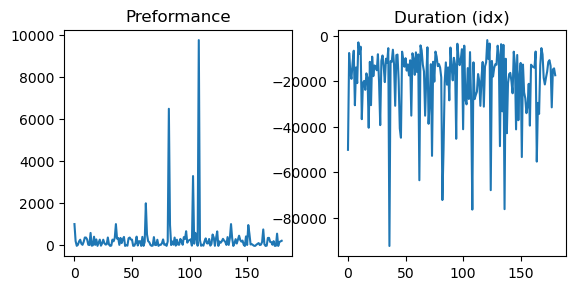

In [5]:
_state, info  = env.reset()

fig = plt.figure(figsize=(10,10))

arr_preformance = np.array(arr_preformance)

arr_preformance[arr_preformance > 10000] = 1000

fig.add_subplot(3,3,1)
plt.title("Preformance")
plt.plot(arr_preformance)


fig.add_subplot(3,3,2)
plt.title("Duration (idx)")
plt.plot(episode_durations)

(array([1.20049465, 1.20759821, 1.19970238, 1.20339835, 1.20339835]),
 201,
 array([0.8373385 , 0.92339444, 0.8405065 , 0.8337036 ], dtype=float32))

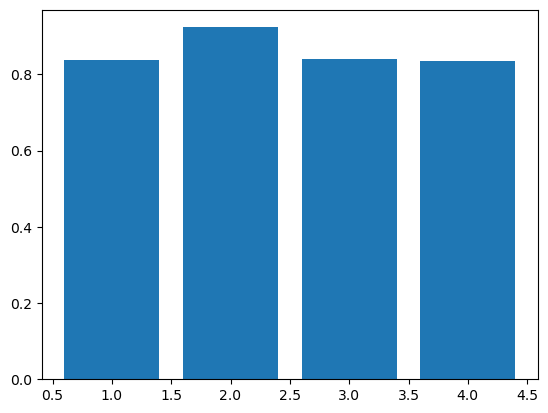

In [ ]:
# env.reset()

if env.idx > 1000:
    
    env.reset()

_state,b,done,c = env.step(0,100)


# with torch.no_grad():
#     for i in range(len(env)):
        
        
#         pred = policy_net(torch.tensor(_state).to(device).type(torch.float))

pred = target_net(torch.tensor(_state).to(device).type(torch.float)).sigmoid()




act =  (pred).detach().cpu().numpy()

plt.bar([1,2,3,4],act)

_state, env.idx, act


In [ ]:
a,b,c,d = env.step(0)

a


array([1.25900185, 1.26079559, 1.24739599, 1.25819397, 1.25819397])

In [ ]:
class DQN  (nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()

        self.Rlayer1 = nn.Linear(10,20)
        self.Rlayer2 = nn.Linear(20,128)

        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3  = nn.Linear(128,128)
        self.layer4 = nn.Linear(128, n_actions)
    def forward(self, x):
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
        r = F.relu(self.Rlayer1(torch.randn(10, device=device)))
        r = F.relu(self.Rlayer2(r))

        x = F.relu(self.layer1(x))
        # x = x* 2
        # print(x)
        x = F.relu(self.layer2(x))

        x = x * r

        x = F.relu(self.layer3(x))
        print(x)

        return 1#x


temp = DQN(4,4).to(device)


rt = torch.randn(4).to(device)

temp(rt)


NameError: name 'nn' is not defined

In [ ]:
random.random()

0.5252861486032403